- Title: Deep Learning From Scratch
- Date: 2020-09-29 09:00
- Category: AI and Machine Learning
- Authors: Grantham Taylor, Amit Gattadahalli
- Summary: Back in 2018, I first saw The Coding Train's series on engineering neural networks from scratch with javascript. I felt it was extremely helpful and have since wanted to do my own from-scratch implementation with python.
- Tags: Deep Learning, Neural Networks, Python
- Demo: https://playground.tensorflow.org
- DemoText: Check out a demo of Tensorflow.
- Banner: https://images.unsplash.com/photo-1597733336794-12d05021d510
- Preview: https://images.unsplash.com/photo-1597733336794-12d05021d510

Back in 2018, I first saw [The Coding Train](https://www.youtube.com/playlist?list=PLRqwX-V7Uu6aCibgK1PTWWu9by6XFdCfh)'s series on engineering neural networks from scratch with javascript. I felt it was extremely helpful and have since wanted to do my own from-scratch implemnetation with python.

As I go along I'll attempt to explain my thought process using layman's terms and as little math as possible.

In [15]:
# (exponential function!)
from math import exp
from itertools import tee

# library for vectors and matrices. I'd have to be crazy to try to recreate matrices with vanilla python objects.
import numpy as np

# some standard helper functions
from sklearn.datasets import make_circles, make_blobs       # example datasets
from sklearn.model_selection import train_test_split        # to randomly split data
from sklearn.utils import shuffle                           # to shuffle the data randomly
from sklearn.metrics import roc_auc_score, roc_curve, auc   # to score classification tasks

# lastly, a nice plotting module for visualizing my rambles
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap as cmap              # a colormap function

I like to think of machine learning (specifically supervised learning tasks) as an automatic calculator. It is but a series of mathematical operations on some inputs to provide a targeted output. Machine learning models can be as simple as a linear regression, but sometimes more complex models are needed for more complicated issues. Neural networks are a complicated model that can mimic the functionality of linear regression, but also may also scale up to be far more complicated.

A common problem in machine learning is that of nonlinearity. That is, complex interactions among the inputs to a model. Below is a very simple example of what a nonlinear interaction looks like. The meaning of vertical axis in relation to the color is dependent on the horizontal axis. Simply put, there is no line that can separate the two colors. It has **linear inseparability**.

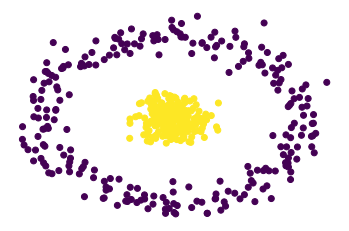

In [16]:
X, y = make_circles(n_samples=500, noise=0.1, factor=0.1)
plt.scatter(X.T[0], X.T[1], c=y)
plt.axis('off'); plt.show()

Neural networks are extremely generalizable and are excellent at learning nonlinear interactions. This does come at a cost though. Neural networks can be quite computationally expensive to train and they are virtually **uninterpretable**. In other words, there is no easy way to tell how a neural net made a prediction.

Neural networks are surprisingly similar to linear regression models. I like to think of a "layer" of a neural networks as just many multiple regression models stacked on top one another, each with their own outputs. A neural network is then just a sequence of these layers. The neural network works by iterating over each layer, **propagating** the outputs of each of them to the next, until the final layer outputs its own final answers.

Before we can get to that, I'm just going to put together some miscellaneous general helper functions.

In [17]:
# this is a handy function to go over the pairs within an iterable object
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

# for example...
for i, j in pairwise(range(1,6)):
    print(f'{i} preceeds {j}')

1 preceeds 2
2 preceeds 3
3 preceeds 4
4 preceeds 5


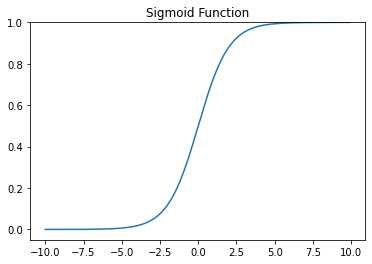

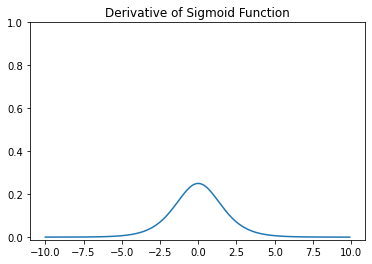

In [18]:
def sigmoid(x):
    if x >= 0:
        z = exp(-x)
        return 1 / (1 + z)
    else:
        z = exp(x)
        return z / (1 + z)

prime = lambda x: sigmoid(x) * (1 - sigmoid(x))

# vectorizing a function just means that I can now easily apply it element-wise to a numpy ndarray
sigmoid = np.vectorize(sigmoid)
prime = np.vectorize(prime)

x = np.arange(-10,10,0.1)

plt.plot(x, sigmoid(x))
plt.title("Sigmoid Function")
plt.ylim(top=1.0)
plt.show()

plt.plot(x, prime(x))
plt.title("Derivative of Sigmoid Function")
plt.ylim(top=1.0)
plt.show()

As I had mentioned above, the essential unit of a neural network is the `layer`. In my implementation `layer` holds two key parameters: `biases` and the `weights`. 

In the same way a `layer` is just a stack of linear regression models, `biases` are a stack of "y-intercepts" for each model. In other words, I implement `biases` as a vector of β₀, one for each node in the `layer`.

Similarly, `weights` is simply a list of coefficients for all the inputs in each linear regression model. Because we have multiple linear models per layer, all of which will have the same number of betas (the number of inputs), `weights` can be implemented as a matrix!

All of the elements in both these objects are initialized to a standard, normal distribution.

We also have a "setting" (hyperparameter): the "activation function". In the same way the output of a logistic regression model is applied to a sigmoid function, we will also apply the sigmoid function to the output of each node in out layer. This is a standard implementation that create additional nonlinearity. The sigmoid function is an arbitrary decision here, and there are far better ones with an easier mathematical implementation (namely ReLU!), but sigmoid is actually easier because it fits the desired range we want for classification (constrained between 0 and 1). For the purposes of correcting errors with calculus, we need to store the derivative of the activation function as well.

I've found that a really simple but effective `Layer` class is very important for the technical implementation of a neural network.

In [19]:
class Layer:

    def __init__(self, ncol, nrow):

        # number of inputs (not including bias) and the number of outputs
        self.shape = (nrow, ncol)

        # values of the weights
        self.weights = np.random.randn(nrow, ncol)

        # values of biases
        self.biases = np.random.randn(nrow, 1)

        # placeholder for unactivated output of layer
        self.outputs = np.ones((nrow, 1))

        # activation function (currently fixed as sigmoid, but may be overridden)
        self.activator = np.vectorize(sigmoid)

        # derivative of activation function (currently fixed as sigmoid, but may be overridden)
        self.primer = np.vectorize(prime)

layer = Layer(3, 5)

print(f'\n weights: shape = {layer.weights.shape} \n {layer.weights}')
print(f'\n biases: shape = {layer.biases.shape} \n {layer.biases}')
print(f'\n sigmoid(3) = {layer.activator(3):.4}')


 weights: shape = (5, 3) 
 [[ 0.58360291 -1.04477239  2.01744448]
 [ 0.80362262  0.70918266  2.00654262]
 [ 0.98185151  0.09150979  0.96289542]
 [ 0.01239768 -0.12943097  0.41800989]
 [-0.07103671 -0.39461366  0.9333896 ]]

 biases: shape = (5, 1) 
 [[ 0.97393686]
 [-1.12518667]
 [-1.46797602]
 [ 0.77734602]
 [ 0.81846104]]

 sigmoid(3) = 0.9526


The first and last layers of a neural network is always called the **input layer** and **output layer**, respectively. All layers in between are called **hidden layers** as they are beyond our interpretation. As the information flows through them, they exist in *latent space*.

The final step is actually stitching these layers together with the ability to communicate with one another. Layers need to communicate in two key ways: (1) sending forward through our hidden layers & (2) sending back blame to correct themselves. These two processes are called **forward propagation** and **backward propagation**, respectively.

Forward propagation is simple enough. For each hidden layer, there is our stack of linear regression models. Each linear regression model takes all outputs of the previous layer, multiplies them by its vector of weights, and then adds its bias and is passed through the layer's activation function. This makes one of the potentially many outputs of that layer, all of which collectively then repeat the same process through the next layer until the output layer is reached. Forward propagation works just like a bunch of linear models hooked up together human-centipede style.

Backward propagation is the hard part. Once the final prediction is made from the output layer, that prediction is compared to the real answer. The difference between the two is the `error` for the final layer. Backward propagation is all about each linear regression model in each layer trying to figure out how responsible it is for this final error, and then, using some calculus, how responsible each of its respective weights (and bias!) is before then sending the aggregated blame back to the previous layer. In layman's terms, backward propagation is just each layer learning from their own mistakes before telling the previous layer how to learn of their own.

In [20]:
class NeuralNetwork:
    
    def __init__(self, *shape, epochs = 50, lr = 0.001):

        # stores number of nodes at each layer
        self.shape = shape

        # placeholder to store pairs of layers
        self.layers = []

        # static hyperparameters
        self.epochs = epochs
        self.lr = lr
            
        # create layers as pairs of inputs
        for inputs, outputs in pairwise(shape):
            self.layers.append(Layer(inputs, outputs))

        # placeholder to store scores for each epoch
        self.scores = []

    def forward(self, x):

        # reshape input to fit succeeding layers
        tensor = np.atleast_2d(x).transpose()

        # for each layer 
        for layer in self.layers:
            
            # multiply all inputs by their respective weights and add their bias
            tensor = layer.outputs = layer.weights.dot(tensor) + layer.biases

            # activate output
            tensor = layer.activator(tensor)

        # return final activated output
        return tensor

    def backward(self, error):

        # error is currently initialized as blame for the final output layer!

        # for each layer in reverse order
        for index, layer in reversed(list(enumerate(self.layers))):

            # find preceeding layer
            predecessor = self.layers[index - 1]

            # define delta as the partial derivative of current layers input with respect to its weights
            delta = error @ predecessor.activator(predecessor.outputs).transpose()

            # change weights by their assigned blame dampened by the learning rate
            layer.weights -= delta * self.lr

            # change biases by their subsequent node's blame dampened by the learning rate
            layer.biases -= error * self.lr

            # update error as the blame for preceeding layer
            error = layer.weights.transpose().dot(error) * predecessor.primer(predecessor.outputs)
  
    def predict(self, X):

        # predict based on each observation in X
        predictions = [self.forward(obs) for obs in X]

        # return array of predictions
        return np.array(predictions).squeeze()

    def score(self, inputs, answer, verbose=True):

        # find predictions of all inputs
        prediction = self.predict(inputs)

        # find aggregated comparison of predictions with the actual answers
        auc = roc_auc_score(answer, prediction)
        
        if verbose:
            print(f'auc = [{auc:.1%}].')

        return auc

    def fit(self, X, y, target = None):

        self.decision_boundary = np.average(y)

        # for each epoch
        for epoch in range(self.epochs):    

            # shuffle data
            X, y = shuffle(X, y)

            # append score
            score = self.score(X, y, verbose=False)
            self.scores.append(score)

            if target is not None:
                if score > target:
                    break

            # for each record in shuffled data 
            for inputs, answer in zip(X, y):

                # predict answer
                prediction = self.forward(inputs)

                # find error of output layer
                error = prediction - answer

                # propagate that backwards
                self.backward(error)


    def plot_errors(self, X, y):

        # this guy plots the first two dimensions of a dataset in a scatterplot
        # each point is colored green if it was correctly predicted, otherwise it is printed red

        predictions = self.predict(X) > self.decision_boundary
        incorrect = np.logical_xor(predictions, y)
        plt.scatter(X.T[0][incorrect], X.T[1][incorrect], c='red')
        plt.scatter(X.T[0][~incorrect], X.T[1][~incorrect], c='green')
        plt.axis('off'); plt.show()

    def plot_scores(self):

        # plots the AUC for each epoch

        x = list(range(len(self.scores)))
        y = self.scores
        plt.plot(x, y)
        plt.ylim(top=1.0, bottom=0.0)
        plt.title("In-sample AUC score prior to each epoch")
        plt.show()

    def graph(self):

        colormap = cmap('RdYlGn', 2)
        
        for index, layer in enumerate(self.layers):
            # initialize set of nodes
            nodes = set()
            output_size, feed_size = layer.shape
            for output_index, output in enumerate(range(output_size)):

                # arrows for output layer
                if index == len(self.layers) - 1:
                    plt.arrow(index + 1.1, output - output_size/2, 0.05, 0, head_width = 0.4, 
                        head_length = 0.05, color="steelblue", length_includes_head =True)

                # add all output nodes (if unique!)
                nodes.add((index + 1, output - output_size/2))

                # plot weights between biases and hidden/output layers
                height = max(self.shape)/2
                value = layer.biases[output_index, 0]
                plt.plot([index, index+1], [height, output - output_size/2],
                    c = colormap(value > 0), linewidth = min(8, abs(value)+0.25))

                # plot biases
                plt.scatter(index, height, s=150, c='white', edgecolors='black', zorder = 10)
                plt.text(index, height, s='1', zorder = 100, 
                    horizontalalignment='center', verticalalignment='center')

                for feed_index, feeder in enumerate(range(feed_size)):

                    # arrows for input layer
                    if index == 0:
                        plt.arrow(index - 0.15, feeder - feed_size/2, 0.05, 0, head_width = 0.4,
                            head_length = 0.05, color="steelblue", length_includes_head =True)

                    # add all input nodes (if unique!)
                    nodes.add((index, feeder - feed_size/2))

                    # plot weights between input and output nodes
                    value = layer.weights[output_index, feed_index]
                    plt.plot([index, index+1], [feeder - feed_size/2, output - output_size/2],
                        c = colormap(value > 0), linewidth = min(8, abs(value)+0.25))

                # plot set of nodes
                for node in nodes:
                    plt.scatter(*node, s=150, c='black', zorder = 10)

        plt.axis('off')
        plt.xlim(xmin=-0.2, xmax=len(self.layers) + 0.3)
        plt.ylim(ymin= -(max(self.shape)/2) - 1)
        plt.show()


Now that the hard part is done, lets check it out.

First, lets build a neural network with only one hidden layer.

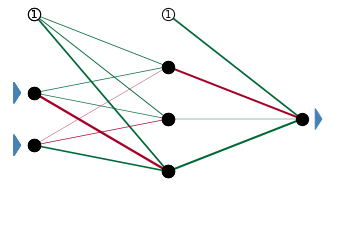

In [21]:
nn = NeuralNetwork(2,3,1, epochs=50)
nn.graph()

Lets get some (linear) data to play with. This should be easily solvable with the equivalent of a logistic regression model. That being said, because linear models don't have to worry about nonlinear interactions, they train significantly faster than neural networks with approximately equal performance. Since we're using a neural network prepared for nonlinear relationships, we still are running over the same data multiple times. This is very computationally inefficient and won't perform significantly better. It's good to confirm that my implementation will be able to solve it though.

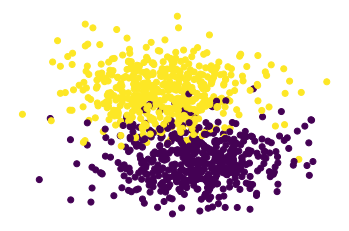

In [22]:
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=3)

plt.scatter(X.T[0], X.T[1], c=y)
plt.axis('off'); plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y)


The data here looks easy enough to solve. It has **linear separability**.

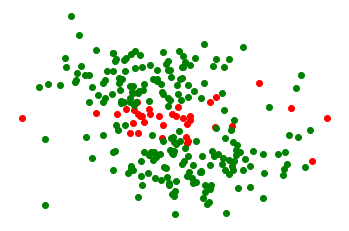

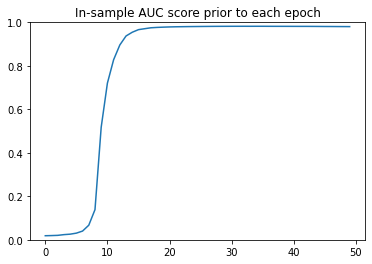

In [23]:
nn.fit(X_train, y_train, target=0.99)
nn.plot_errors(X_test, y_test)
nn.plot_scores()

The neural network learned to use its degrees of freedom to place a decision boundary between the two clusters.

With our test data, the neural net was able to predict the colors of almost all the points. Any mistakes it made are now colored in red.

An AUC of 100% is perfect. Ours is almost there, but still made a few mistakes. But that is to be expected - some of the colors overlapped.

Now lets look back at our nonlinear problem.

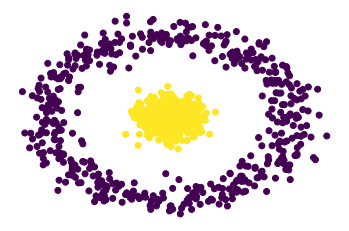

In [24]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.1)
plt.scatter(X.T[0], X.T[1], c=y)
plt.axis('off'); plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y)

We are using this data generator for the simplicity of visualizing its two dimensions - in practice, data hardly looks like this. Furthermore, because the rings are centered at (0,0), we could simply use some *feature engineering* to make a very simple third variable equivalent to the euclidean distance of any point to center. This would give a single variable perfectly able to explain the color.

$$ x_3 = \sqrt{x_1^2 + x_2^2} $$

Regardless, without such feature engineering, there is no way to place a line anywhere to divide the two colors. A "logistic regression" model, (a neural network without any hidden layers) is doomed to fail here.

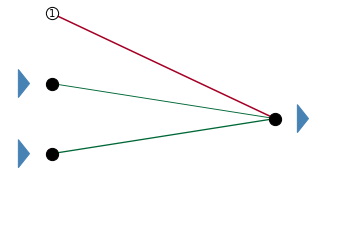

In [25]:
nn = NeuralNetwork(2, 1, epochs = 20)
nn.graph()

If we use a neural network without any hidden layers, we won't be able to pick up on the nonlinear interactions. It tries to place a line between all of the data and will inevitably fail.

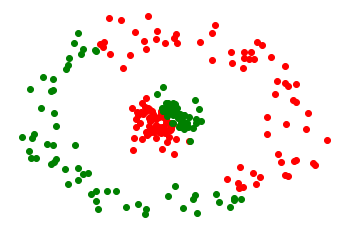

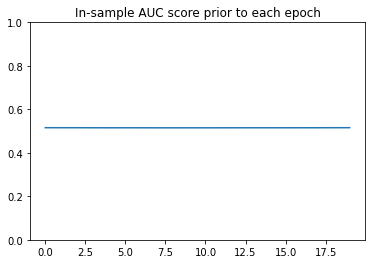

In [26]:
nn.fit(X_train, y_train)
nn.plot_errors(X_test, y_test)
nn.plot_scores()

An AUC of 50% is equivalent to guessing randomly. This model offers no value.

Lets use that exact same data but with a more complex neural network. This neural network has enough degrees of freedom to make latent variables on its own. This means it can learn that the problem is nonlinear and will, of its own accord, learn how to place some nonlinear decision boundary between the colors.

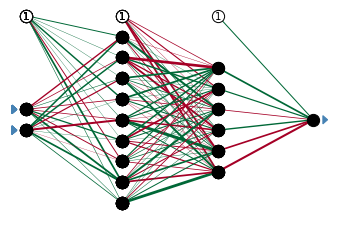

In [27]:
nn = NeuralNetwork(2, 9, 6, 1, epochs=500)
nn.graph()

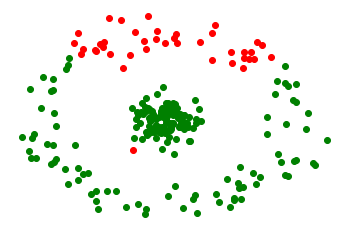

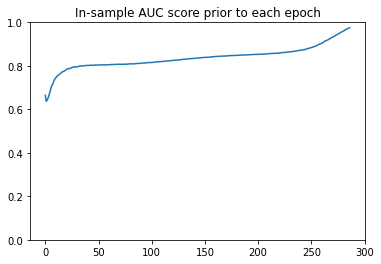

In [28]:
nn.fit(X_train, y_train, target=0.975)
nn.plot_errors(X_test, y_test)
nn.plot_scores()

The model is significantly better than guessing randomly, but still misses a section of the outer ring. Looks like it formed some sort of slanted parabola around the center, but I cut it off before it had time to tie the parabola into a circle around the center. Based on the high AUC I get the impression it was pretty unsure about those mistakes too.

Nice, so the neural network almost learned how to solve this very simple problem.

Here are but a few of the many shortcomings of my very simple implementation:

1. It doesn't use **batch learning**. That is, it is running backwards propagation for each record it sees. This is very inefficient and computationally expensive. It is standard to aggregate errors before backpropagating them to save time.

2. It is dependent loops and is not **threaded**. This is perhaps one of the biggest drawbacks and will slow down computation time by well over 100x... It is a limitation of using Python to write this instead of a lower-level language such as C or Rust. Since neural networks use matrix multiplication for forwards and backwards propagation, they are able to run extremely fast if they are able to be run on GPUs.

3. My **learning rate** is static - this will lead to diminishing efficiency as the neural network approaches its parameters reach their optimal states.

Libraries such as Torch and Tensorflow are built to provide all of this functionality, including a ton more, all of which is way more computationally efficient with just a few lines of code. That being said, I feel as though recreating their most basic functions helped me learn alot about what goes on underneath the hood.